In [1]:
# https://docs.data.nasdaq.com/v1.0/docs/python-installation

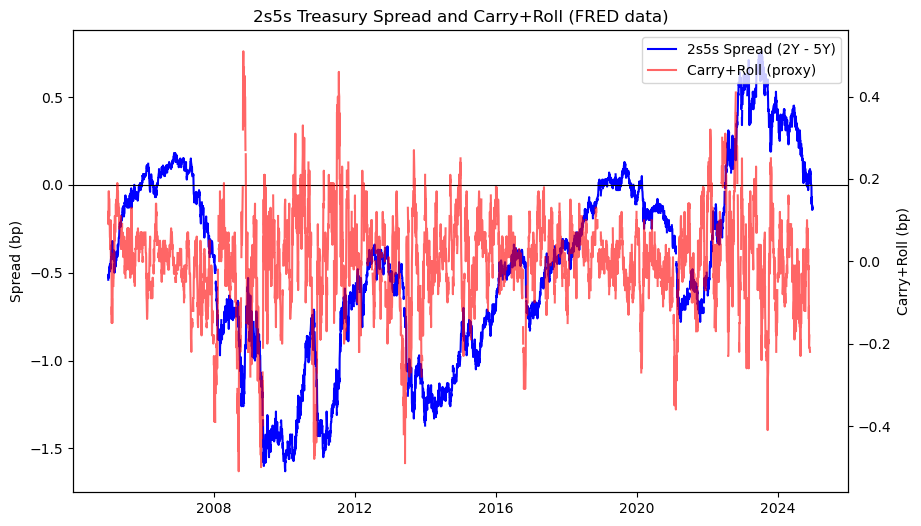

In [8]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime

start = datetime.datetime(2005, 1, 1)
end = datetime.datetime(2025, 1, 1)

# Pull from FRED
y2 = web.DataReader("DGS2", "fred", start, end)
y5 = web.DataReader("DGS5", "fred", start, end)

# Combine
df = pd.concat([y2, y5], axis=1)
df.columns = ["2Y", "5Y"]

# 2s5s spread
df["2s5s"] = df["2Y"] - df["5Y"]

# Simple carry+roll proxy (1M lookahead in yields)
roll_2s = df["2Y"].shift(-21) - df["2Y"]
roll_5s = df["5Y"].shift(-21) - df["5Y"]
df["CarryRoll"] = roll_2s - roll_5s

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df.index, df["2s5s"], color="blue", label="2s5s Spread (2Y - 5Y)")
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_ylabel("Spread (bp)")
ax1.set_title("2s5s Treasury Spread and Carry+Roll (FRED data)")

ax2 = ax1.twinx()
ax2.plot(df.index, df["CarryRoll"], color="red", alpha=0.6, label="Carry+Roll (proxy)")
ax2.set_ylabel("Carry+Roll (bp)")

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc="upper right")

plt.show()


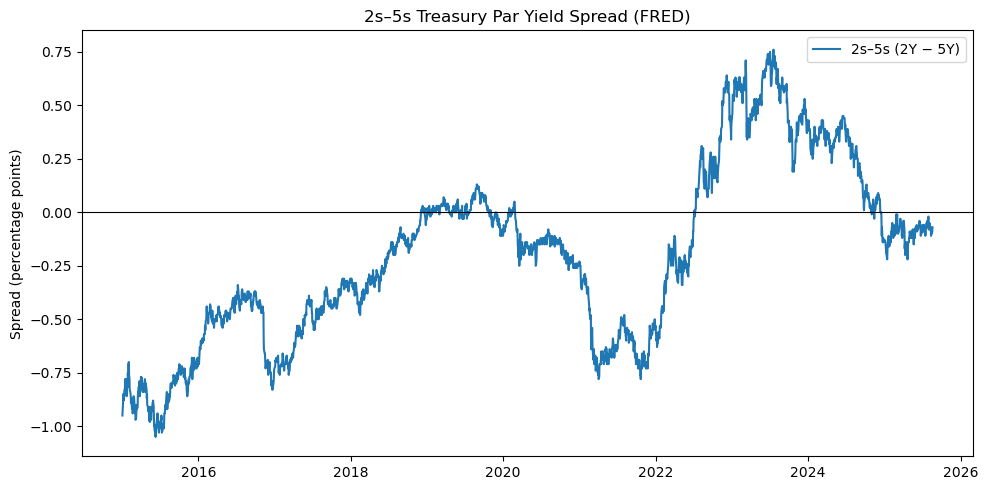

In [11]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from scipy.interpolate import CubicSpline

# ---------- 1) Download FRED par yield curve ----------
start = dt.datetime(2015,1,1)
end   = dt.datetime.today()

fred_symbols = {
    "DGS1MO": 1/12,  # years
    "DGS3MO": 3/12,
    "DGS6MO": 6/12,
    "DGS1":   1.0,
    "DGS2":   2.0,
    "DGS3":   3.0,
    "DGS5":   5.0,
    "DGS7":   7.0,
    "DGS10":  10.0,
    "DGS20":  20.0,
    "DGS30":  30.0,
}

df = pd.concat(
    [web.DataReader(sym, "fred", start, end).rename(columns={sym: ten}) 
     for sym, ten in fred_symbols.items()],
    axis=1
)
# Convert columns to float maturity in years
df.columns = list(fred_symbols.values())
df = df.sort_index().dropna(how="all").ffill()

# ---------- 2) 2s–5s spread plot ----------
y2 = df[2.0]
y5 = df[5.0]
spread_2s5s = y2 - y5  # NOTE: 2s - 5s

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(spread_2s5s.index, spread_2s5s, label="2s–5s (2Y − 5Y)")
ax.axhline(0, lw=0.8, color="black")
ax.set_title("2s–5s Treasury Par Yield Spread (FRED)")
ax.set_ylabel("Spread (percentage points)")
ax.legend()
plt.tight_layout()
plt.show()

=== Curve snapshot (latest FRED date) ===
2Y = 3.75%   5Y = 3.82%
2s–5s = -0.07 bp

=== DV01 (per $100 face) ===
DV01_2Y = 0.0000 $/bp   DV01_5Y = 0.0000 $/bp   Hedge ratio H = 0.500

=== 1M Carry+Roll (curve-held) ===
2Y TR = 0.606%   5Y TR (short) = -0.584% (sign reversed for short)
Net TR (DV01-neutral, per $100 face on 2Y leg) = 0.314%
Approx $P&L for $100mm 2Y notional = $314,243


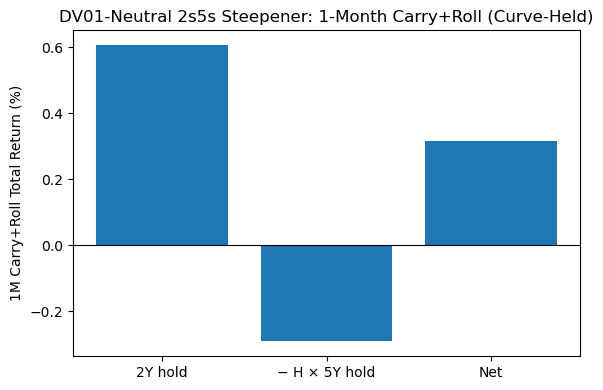

In [12]:


# ---------- 3) Carry + Roll for a DV01-neutral 2s5s steepener ----------
# Curve-hold assumption: in 1 month, the curve is unchanged in *maturity space*.
# We approximate a 1-month horizon (h = 1/12 year).
h = 1/12

# Take the latest available curve snapshot
curve = df.iloc[-1].dropna()
terms = np.array(curve.index, dtype=float)
ylds  = np.array(curve.values, dtype=float) / 100.0  # convert to decimals

# Build cubic spline in maturity (years) for interpolation
spline = CubicSpline(terms, ylds, bc_type="natural")

def bond_price_par(y, T, freq=2):
    """
    Price of a par bond (coupon = y) with yield y, maturity T years, frequency freq.
    Face = 100. Returns *dirty* price at settlement.
    """
    if T <= 0:
        return 100.0
    c = y / freq
    n = int(np.round(T*freq))
    if n < 1: 
        # If less than one coupon remains, treat as single payment with accrual later
        n = 1
    times = np.arange(1, n+1) / freq
    # Adjust last time to be exactly T
    times[-1] = T
    cashflows = np.full(n, 100*c)
    cashflows[-1] += 100.0
    disc = 1.0 / (1.0 + y/freq)**(times*freq)
    return float(np.sum(cashflows * disc))

def dv01_par(y, T, freq=2, bump=1e-4):
    """DV01 (per 1bp = 0.0001 change in y) for a par bond priced off yield y."""
    p0 = bond_price_par(y, T, freq)
    p_up = bond_price_par(y + bump, T, freq)
    return (p_up - p0) / (bump*10000.0)  # $ per bp per 100 face (will be negative); take abs later

def total_return_1m(y_T, y_Tminus, T, h=1/12, freq=2):
    """
    1-month hold total return for a par bond:
    - Price today at yield y_T, maturity T  (≈ 100)
    - After h months, maturity T-h, market yield = y_Tminus (curve frozen)
    - Earn coupon accrual over h, then mark to new dirty price
    Returns % total return over the month.
    """
    P0 = bond_price_par(y_T, T, freq)
    # Accrued coupon over h (linear accrual within the semiannual period)
    accrual = (y_T/freq) * 100.0 * (h * freq)  # fraction of a coupon
    P1 = bond_price_par(y_Tminus, max(T - h, 0), freq)
    TR = (P1 + accrual - P0) / P0
    return TR

# Current 2Y/5Y yields (decimals)
y2_now = float(spline(2.0))
y5_now = float(spline(5.0))

# 1-month-forward (curve-held) yields at 23m and 59m
y_23m = float(spline(2.0 - h))
y_59m = float(spline(5.0 - h))

# DV01s per $100 face (absolute)
dv01_2 = abs(dv01_par(y2_now, 2.0))
dv01_5 = abs(dv01_par(y5_now, 5.0))

# DV01-neutral hedge ratio: notional_5 = notional_2 * dv01_2 / dv01_5
H = dv01_2 / dv01_5

# 1-month total return (carry+roll) for each leg
tr_2 = total_return_1m(y2_now, y_23m, 2.0, h=h)   # long 2y
tr_5 = total_return_1m(y5_now, y_59m, 5.0, h=h)   # short 5y -> subtract

# Net TR for DV01-neutral steepener (per $100 face on 2y leg)
net_TR_per100 = tr_2 - H * tr_5

# Scale to $ P&L for $100mm notional on 2y leg
notional_2 = 100_000_000
# Price per $100 face today (≈ 100). Use this to translate %TR to $.
P2_today = bond_price_par(y2_now, 2.0)
dollar_PL = net_TR_per100 * (notional_2 / 100.0) * P2_today

print("=== Curve snapshot (latest FRED date) ===")
print(f"2Y = {y2_now*100:.2f}%   5Y = {y5_now*100:.2f}%")
print(f"2s–5s = {(y2_now - y5_now)*100:.2f} bp")

print("\n=== DV01 (per $100 face) ===")
print(f"DV01_2Y = {dv01_2:.4f} $/bp   DV01_5Y = {dv01_5:.4f} $/bp   Hedge ratio H = {H:.3f}")

print("\n=== 1M Carry+Roll (curve-held) ===")
print(f"2Y TR = {tr_2*100:.3f}%   5Y TR (short) = {(-tr_5)*100:.3f}% (sign reversed for short)")
print(f"Net TR (DV01-neutral, per $100 face on 2Y leg) = {net_TR_per100*100:.3f}%")
print(f"Approx $P&L for $100mm 2Y notional = ${dollar_PL:,.0f}")

# Optional: small bar viz of components
labels = ["2Y hold", "− H × 5Y hold", "Net"]
vals = [tr_2*100, -H*tr_5*100, net_TR_per100*100]
plt.figure(figsize=(6,4))
plt.bar(labels, vals)
plt.axhline(0, color="black", lw=0.8)
plt.ylabel("1M Carry+Roll Total Return (%)")
plt.title("DV01-Neutral 2s5s Steepener: 1-Month Carry+Roll (Curve-Held)")
plt.tight_layout()
plt.show()


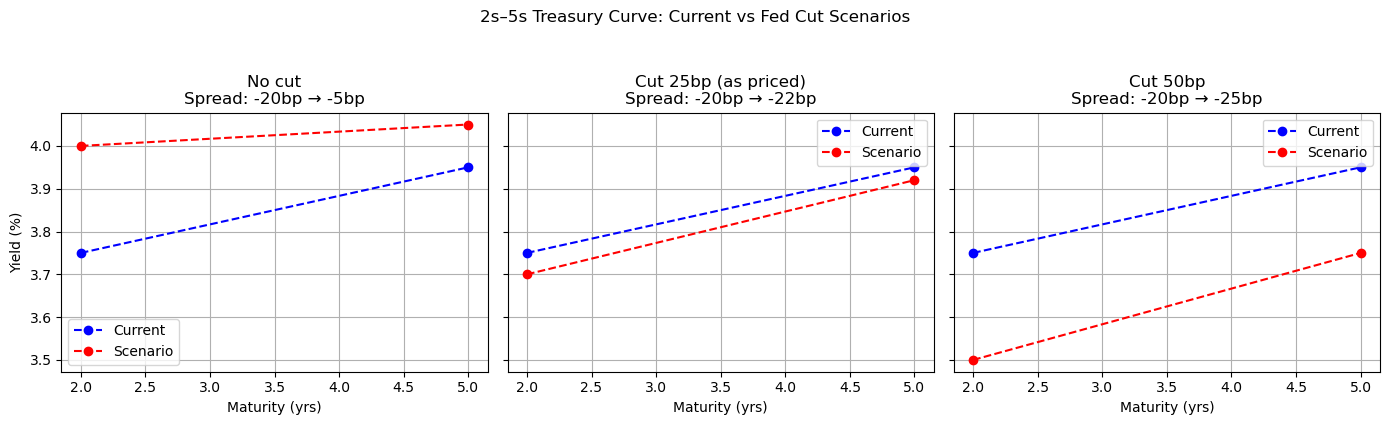

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Current yields (stylized, %)
y2_current = 3.75
y5_current = 3.95

# Scenarios: Fed no cut, Fed 25bp cut, Fed 50bp cut
scenarios = ["No cut", "Cut 25bp (as priced)", "Cut 50bp"]
y2_scenarios = [4.00, 3.70, 3.50]   # 2Y yield under each scenario
y5_scenarios = [4.05, 3.92, 3.75]   # 5Y yield under each scenario

# Build curves for plotting (2y and 5y only, simple segment)
x = [2,5]

fig, axes = plt.subplots(1,3, figsize=(14,4), sharey=True)

for i, ax in enumerate(axes):
    ax.plot(x, [y2_current, y5_current], 'o--', label="Current", color="blue")
    ax.plot(x, [y2_scenarios[i], y5_scenarios[i]], 'o--', label="Scenario", color="red")
    spread_current = y2_current - y5_current
    spread_scenario = y2_scenarios[i] - y5_scenarios[i]
    ax.set_title(f"{scenarios[i]}\nSpread: {spread_current*100:.0f}bp → {spread_scenario*100:.0f}bp")
    ax.set_xlabel("Maturity (yrs)")
    ax.grid(True)
    if i==0:
        ax.set_ylabel("Yield (%)")
    ax.legend()

plt.suptitle("2s–5s Treasury Curve: Current vs Fed Cut Scenarios", y=1.05)
plt.tight_layout()
plt.show()


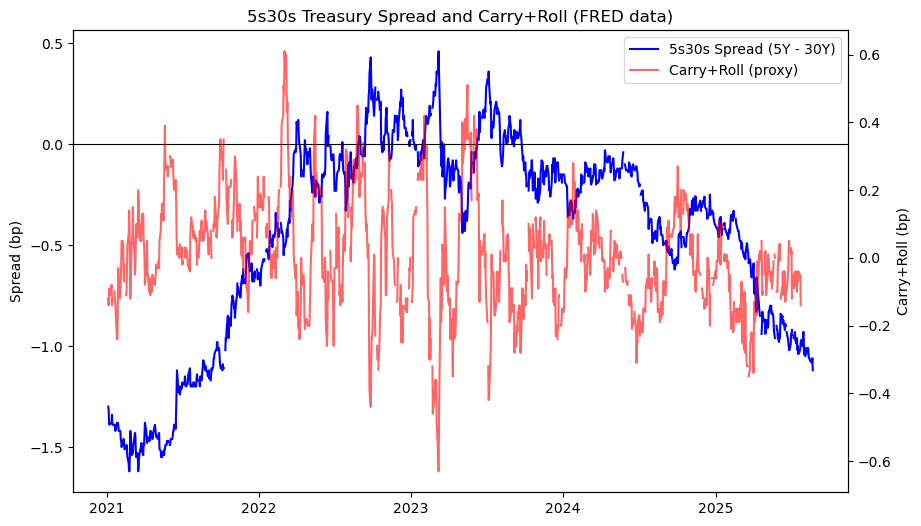

In [19]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime

start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2025, 8, 25)

# Pull from FRED
y30 = web.DataReader("DGS30", "fred", start, end)
y5 = web.DataReader("DGS5", "fred", start, end)

# Combine
df = pd.concat([y30, y5], axis=1)
df.columns = ["30Y", "5Y"]

# 2s5s spread
df["5s30s"] = df["5Y"] - df["30Y"]

# Simple carry+roll proxy (1M lookahead in yields)
roll_5s = df["5Y"].shift(-21) - df["5Y"]
roll_30s = df["30Y"].shift(-21) - df["30Y"]
df["CarryRoll"] = roll_5s - roll_30s

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df.index, df["5s30s"], color="blue", label="5s30s Spread (5Y - 30Y)")
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_ylabel("Spread (bp)")
ax1.set_title("5s30s Treasury Spread and Carry+Roll (FRED data)")

ax2 = ax1.twinx()
ax2.plot(df.index, df["CarryRoll"], color="red", alpha=0.6, label="Carry+Roll (proxy)")
ax2.set_ylabel("Carry+Roll (bp)")

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc="upper right")

plt.show()



In [20]:
df

,30Y,5Y,5s30s,CarryRoll
DATE,,,,
2021-01-01,NaN,NaN,NaN,NaN
2021-01-04,1.66,0.36,-1.30,-0.12
2021-01-05,1.70,0.38,-1.32,-0.14
2021-01-06,1.81,0.43,-1.38,-0.09
2021-01-07,1.85,0.46,-1.39,-0.11
...,...,...,...,...
2025-08-18,4.94,3.86,-1.08,NaN
2025-08-19,4.90,3.82,-1.08,NaN
2025-08-20,4.89,3.81,-1.08,NaN


### 2s10s

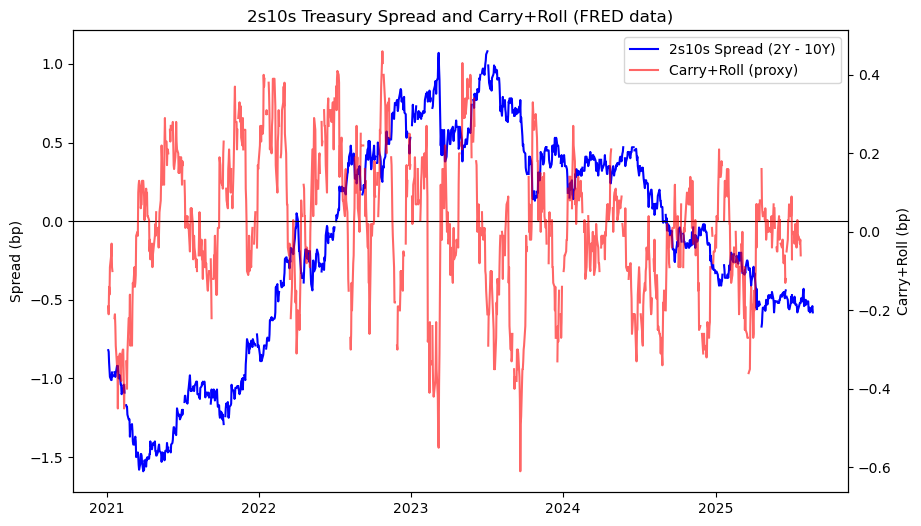

In [18]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime

start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2025, 8, 25)

# Pull from FRED
y2 = web.DataReader("DGS2", "fred", start, end)
y10 = web.DataReader("DGS10", "fred", start, end)

# Combine
df = pd.concat([y2, y10], axis=1)
df.columns = ["2Y", "10Y"]

# 2s5s spread
df["2s10s"] = df["2Y"] - df["10Y"]

# Simple carry+roll proxy (1M lookahead in yields)
roll_2s = df["2Y"].shift(-21) - df["2Y"]
roll_10s = df["10Y"].shift(-21) - df["10Y"]
df["CarryRoll"] = roll_2s - roll_10s

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df.index, df["2s10s"], color="blue", label="2s10s Spread (2Y - 10Y)")
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_ylabel("Spread (bp)")
ax1.set_title("2s10s Treasury Spread and Carry+Roll (FRED data)")

ax2 = ax1.twinx()
ax2.plot(df.index, df["CarryRoll"], color="red", alpha=0.6, label="Carry+Roll (proxy)")
ax2.set_ylabel("Carry+Roll (bp)")

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc="upper right")

plt.show()


